In [1]:
!pip install --upgrade pip
!pip install datasets accelerate transformers tqdm torch torchvision torchaudio requests "urllib3<2" scikit-learn matplotlib
!pip install -U accelerate
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no


In [2]:
from transformers import ViTFeatureExtractor
from transformers import TrainingArguments
from transformers import ViTForImageClassification, Trainer, TrainingArguments
import torch
import numpy as np
from datasets import load_dataset



/home/tommydl/TDT05-Project-23/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
x = torch.ones(1).to(device)
print(x)

tensor([1.], device='cuda:0')


In [4]:
def load_data():
    d_types = ['train'] # 60k images
    datasets = []
    for d in d_types:
        datasets.append(load_dataset(
            'mnist',
            split=d,
        ))
    return datasets

dataset = load_data()[0].map(lambda x: {'image': torch.tensor(np.repeat(np.array(x['image'])[:, :, np.newaxis], 3, axis=2)), 'label': x['label']})



In [5]:
# 98% for validation, 1% for test and 1% for training
split = dataset.train_test_split(test_size=0.98)
temp_split = split['train'].train_test_split(test_size=1/2)
dataset_train = temp_split['train']
dataset_test = temp_split['test']
dataset_valid = split['test']
dataset_train, dataset_test, dataset_valid

(Dataset({
     features: ['image', 'label'],
     num_rows: 600
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 600
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 58800
 }))

In [6]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label'].names
num_classes, labels

(10, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [7]:
dataset_train['image'][1].size

(28, 28)

In [8]:
# import feature extraction model
model_id = 'google/vit-base-patch16-224-in21k'

feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)
model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
).to(device)

model.num_parameters()

/home/tommydl/TDT05-Project-23/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85806346

In [9]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['labels'] = batch['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)
# ... and the validation dataset
prepared_valid = dataset_valid.with_transform(preprocess)



In [10]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


/tmp/ipykernel_48743/1389652664.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
eval_save_step = 50

# training the model
training_args = TrainingArguments(
  output_dir="./vit_model",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=10,
  save_steps=eval_save_step,
  eval_steps=eval_save_step,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  optim='adamw_torch',
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

train_results = trainer.train(resume_from_checkpoint=True)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

 32%|███▏      | 60/190 [00:07<00:25,  5.05it/s]

{'loss': 0.1736, 'learning_rate': 0.0001368421052631579, 'epoch': 3.16}


 37%|███▋      | 70/190 [00:10<00:35,  3.41it/s]

{'loss': 0.2003, 'learning_rate': 0.0001263157894736842, 'epoch': 3.68}


 42%|████▏     | 80/190 [00:13<00:32,  3.34it/s]

{'loss': 0.1419, 'learning_rate': 0.00011578947368421053, 'epoch': 4.21}


 47%|████▋     | 90/190 [00:16<00:29,  3.42it/s]

{'loss': 0.1381, 'learning_rate': 0.00010526315789473685, 'epoch': 4.74}


 53%|█████▎    | 100/190 [00:19<00:26,  3.36it/s]

{'loss': 0.0766, 'learning_rate': 9.473684210526316e-05, 'epoch': 5.26}


                                                 
 53%|█████▎    | 100/190 [00:22<00:26,  3.36it/s]

{'eval_loss': 0.1437034010887146, 'eval_accuracy': 0.9783333333333334, 'eval_runtime': 3.2793, 'eval_samples_per_second': 182.967, 'eval_steps_per_second': 22.871, 'epoch': 5.26}


 58%|█████▊    | 110/190 [00:26<00:26,  3.02it/s]

{'loss': 0.0737, 'learning_rate': 8.421052631578948e-05, 'epoch': 5.79}


 63%|██████▎   | 120/190 [00:29<00:19,  3.57it/s]

{'loss': 0.0587, 'learning_rate': 7.368421052631579e-05, 'epoch': 6.32}


 68%|██████▊   | 130/190 [00:31<00:16,  3.55it/s]

{'loss': 0.0509, 'learning_rate': 6.31578947368421e-05, 'epoch': 6.84}


 74%|███████▎  | 140/190 [00:34<00:13,  3.58it/s]

{'loss': 0.0583, 'learning_rate': 5.2631578947368424e-05, 'epoch': 7.37}


 79%|███████▉  | 150/190 [00:37<00:11,  3.51it/s]

{'loss': 0.0482, 'learning_rate': 4.210526315789474e-05, 'epoch': 7.89}


                                                 
 79%|███████▉  | 150/190 [00:40<00:11,  3.51it/s]

{'eval_loss': 0.13954751193523407, 'eval_accuracy': 0.9716666666666667, 'eval_runtime': 3.3737, 'eval_samples_per_second': 177.848, 'eval_steps_per_second': 22.231, 'epoch': 7.89}


 84%|████████▍ | 160/190 [00:44<00:10,  2.95it/s]

{'loss': 0.0485, 'learning_rate': 3.157894736842105e-05, 'epoch': 8.42}


 90%|█████████ | 171/190 [00:47<00:04,  4.16it/s]

{'loss': 0.0429, 'learning_rate': 2.105263157894737e-05, 'epoch': 8.95}


 95%|█████████▍| 180/190 [00:50<00:02,  3.54it/s]

{'loss': 0.0414, 'learning_rate': 1.0526315789473684e-05, 'epoch': 9.47}


{'loss': 0.0415, 'learning_rate': 0.0, 'epoch': 10.0}


100%|██████████| 190/190 [00:53<00:00,  3.57it/s]


{'train_runtime': 53.2201, 'train_samples_per_second': 112.739, 'train_steps_per_second': 3.57, 'train_loss': 0.06286468631342838, 'epoch': 10.0}
***** train metrics *****
  epoch                    =       10.0
  train_loss               =     0.0629
  train_runtime            = 0:00:53.22
  train_samples_per_second =    112.739
  train_steps_per_second   =       3.57


In [12]:
# evaluate with validation
metrics = trainer.evaluate(prepared_valid)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|██████████| 7350/7350 [05:21<00:00, 22.84it/s]


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9798
  eval_loss               =      0.111
  eval_runtime            = 0:05:21.90
  eval_samples_per_second =    182.662
  eval_steps_per_second   =     22.833


Text(0.5, 1.0, 'ViT: Loss over train steps')

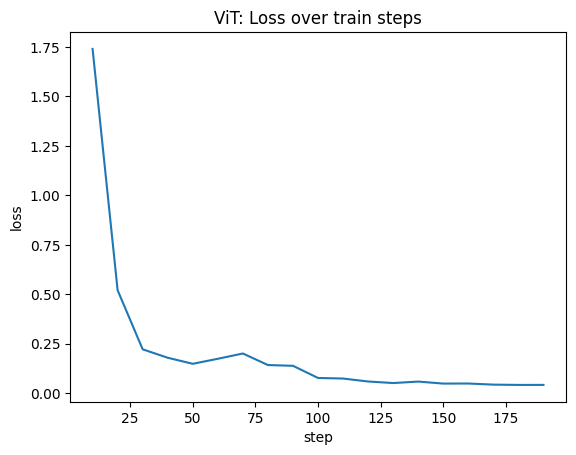

In [17]:
from matplotlib import pyplot as plt

x = [log['step'] for log in trainer.state.log_history if 'loss' in log]
y = [log['loss'] for log in trainer.state.log_history if 'loss' in log]


# y axis is loss
# x axis is step
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('ViT: Loss over train steps')


In [18]:
# fine tuned model
# import our fine-tuned model
model_name_or_path = './vit_model'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

model_finetuned.num_parameters()


85806346

In [19]:
def predict(image):
    inputs = feature_extractor_finetuned(image["image"], return_tensors="pt")
    # extract the actual label of the first image of the testing dataset
    actual_label = image["label"]

    with torch.no_grad():
        logits = model_finetuned(**inputs).logits

    predicted_label = logits.argmax(-1).item()
    return predicted_label


In [21]:
import random
index = random.randint(0, len(dataset_valid)-1)
print("Predicted "+str(predict(dataset_valid[index])))
dataset_valid[index]["image"]

Predicted 4
